In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import STOPWORDS, WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

2025-03-02 15:56:22.832806: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 15:56:23.085814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740902183.180897   17573 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740902183.205084   17573 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 15:56:23.392116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Competition description
In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. 

Submissions are evaluated using F1 between the predicted and expected answers.

## Exploratory Data Analysis

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print(df_train.shape, df_test.shape)

(7613, 5) (3263, 4)


In [4]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
# Check for NaN count

print("Training data:")
for column in df_train.columns:
    missing = df_train[column].isna().sum()
    print(column, missing, round(missing / len(df_train) *100, 2))
print("Testing data")
for column in df_test.columns:
    missing = df_test[column].isna().sum()
    print(column, missing, round(missing / len(df_train) *100, 2))

Training data:
id 0 0.0
keyword 61 0.8
location 2533 33.27
text 0 0.0
target 0 0.0
Testing data
id 0 0.0
keyword 26 0.34
location 1105 14.51
text 0 0.0


Per observation, the amount of missing values in `location` column is significant. Therefore it should not be used as any feature for training.

In [6]:
df_train["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

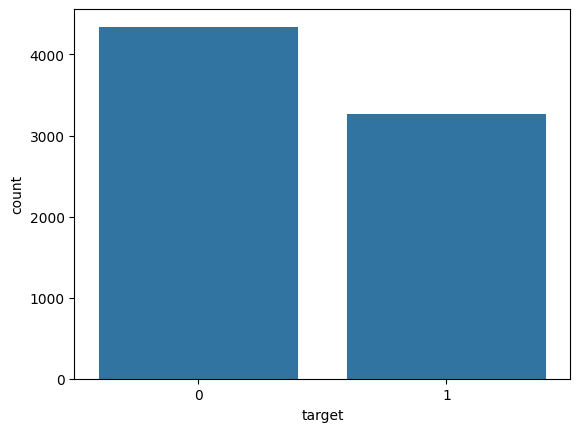

In [7]:
sns.barplot(df_train["target"].value_counts())

Per observation, this dataset provides a good balance between the number of positive and negative samples. Therefore, the dataset does not require any resampling.

The problem becomes a simple binary classification.

Word distribution by WordCloud

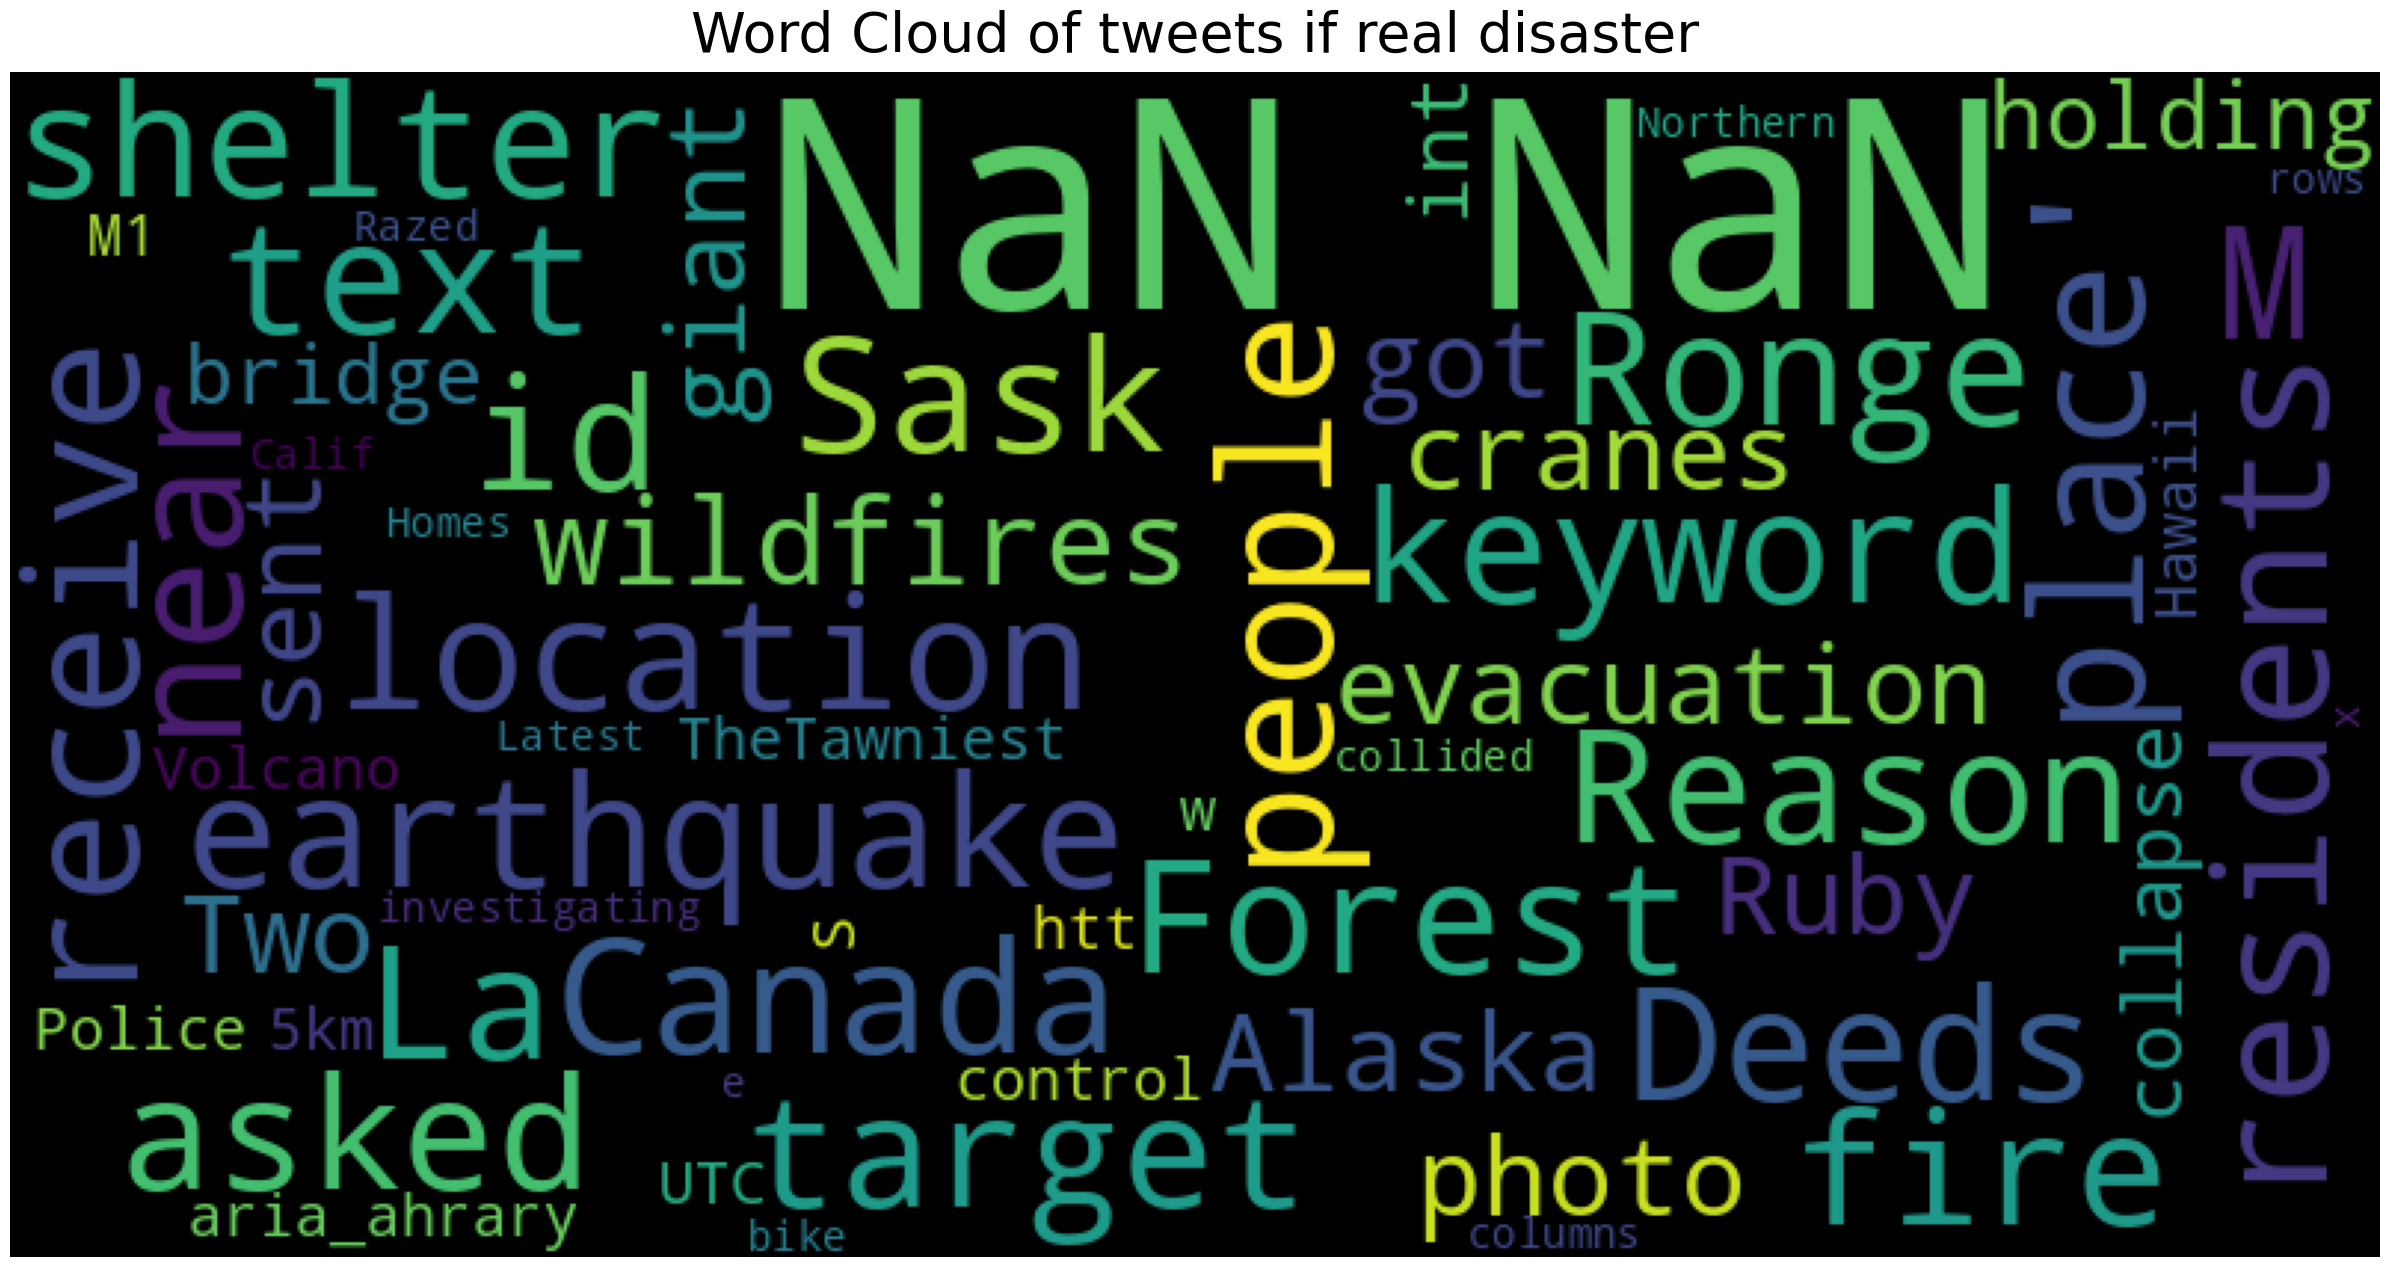

In [8]:
## https://www.kaggle.com/aashita/word-clouds-of-various-shapes
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()  
    
plot_wordcloud(df_train[df_train["target"]==1], title="Word Cloud of tweets if real disaster")

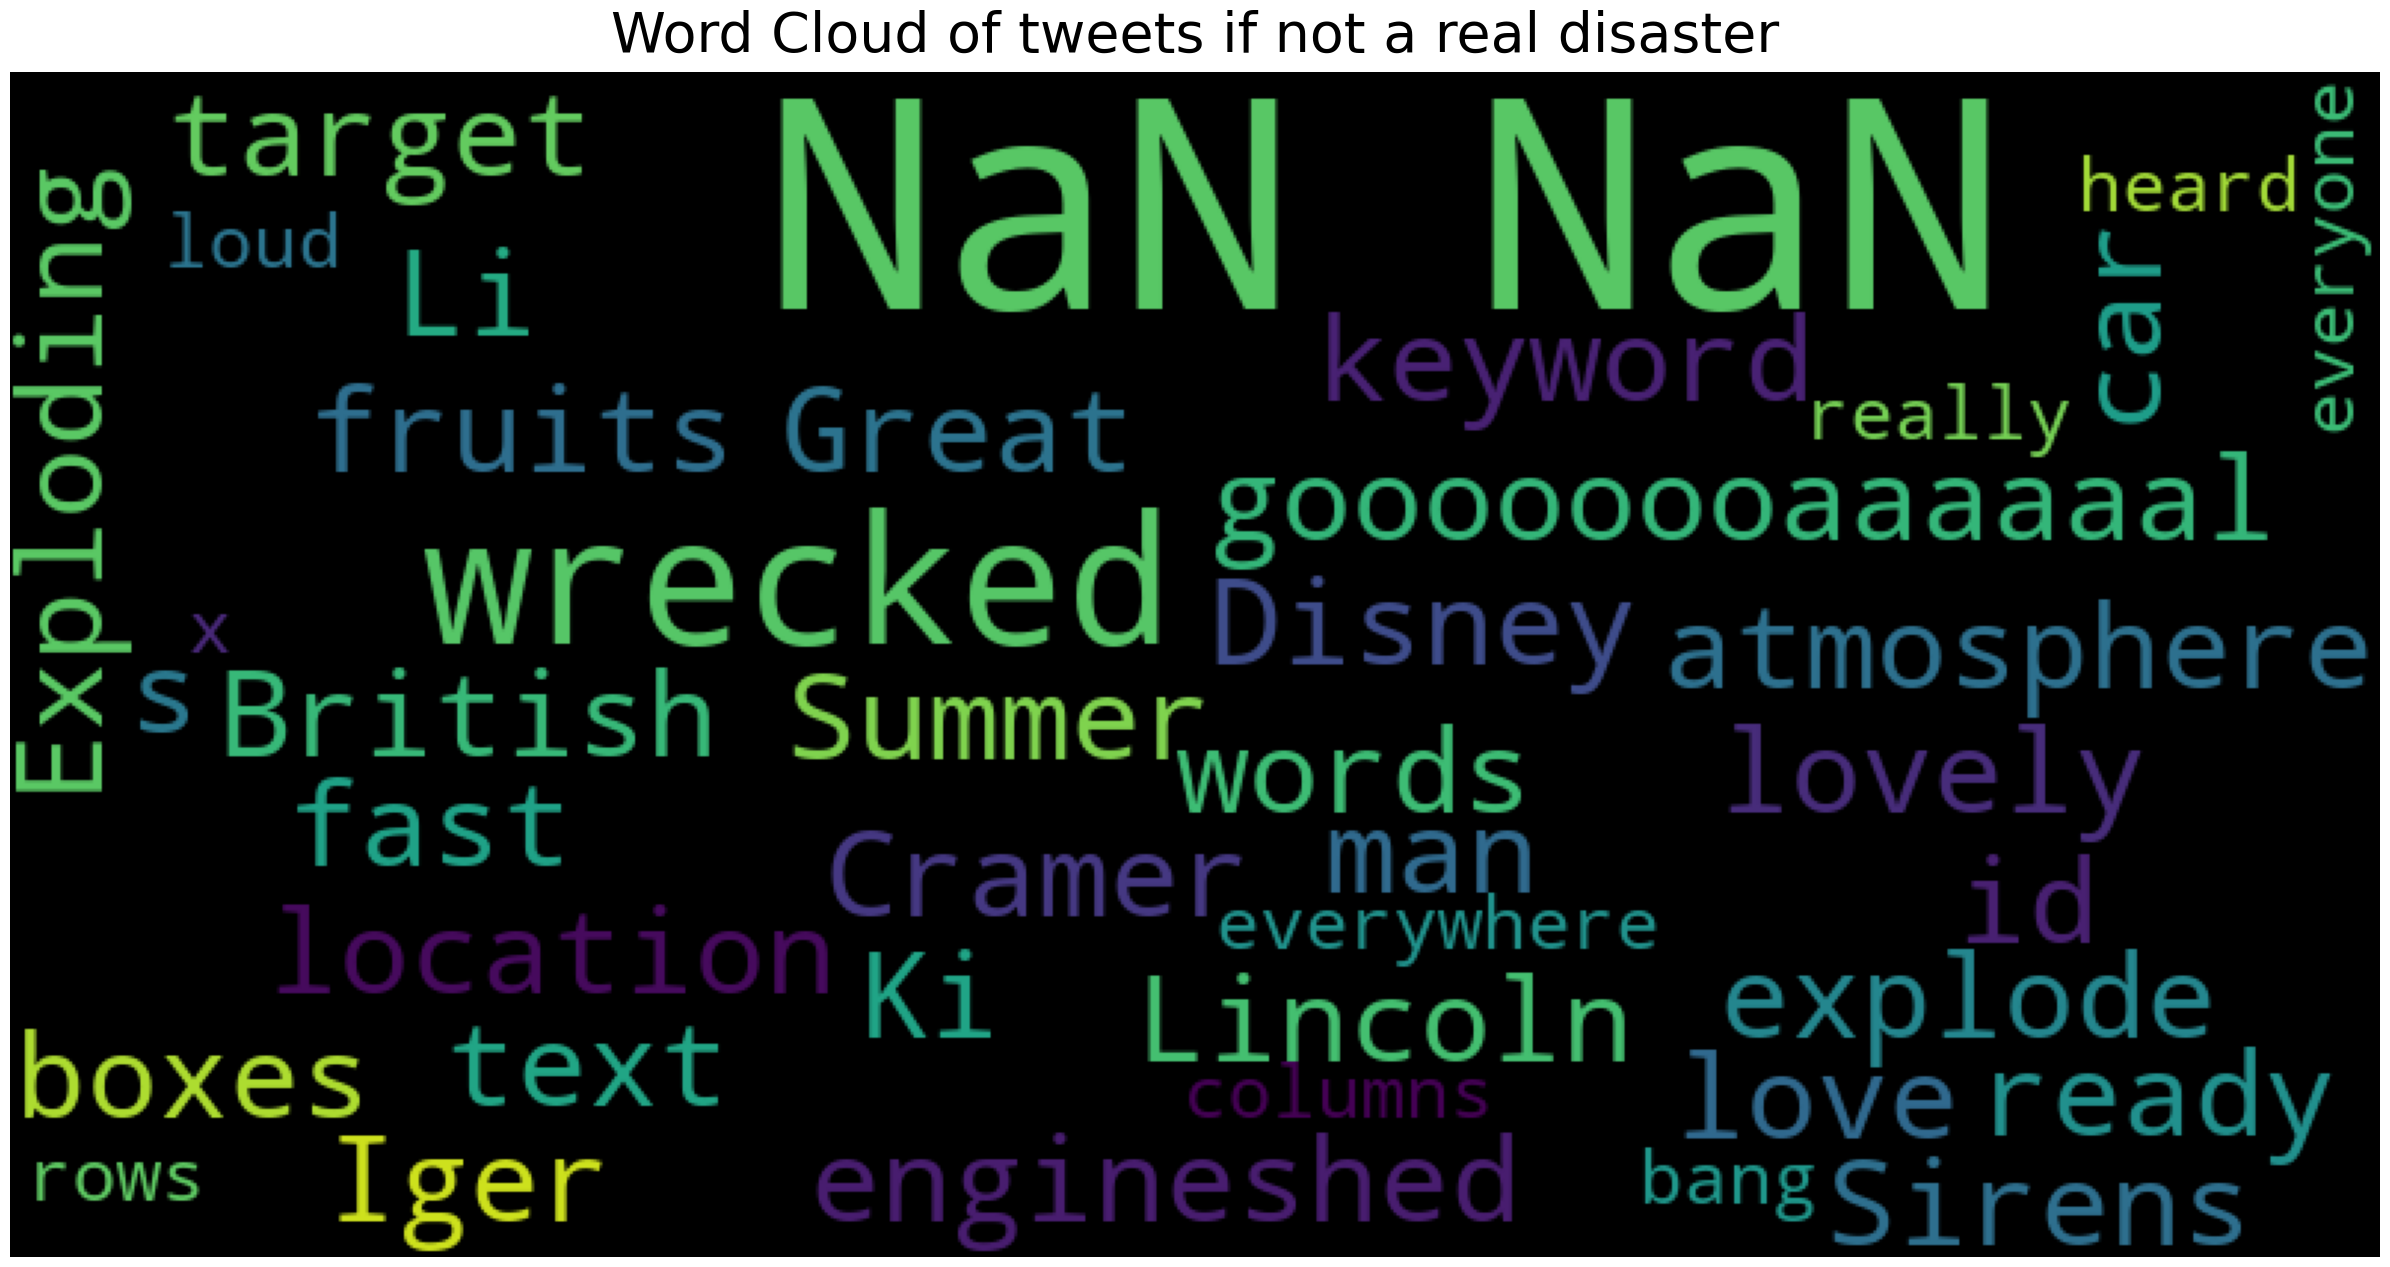

In [9]:
plot_wordcloud(df_train[df_train["target"]==0], title="Word Cloud of tweets if not a real disaster")

Comparing the above 2 word clouds, we can see that the distribution of words in the disaster tweets is different from the distribution of words in the non-disaster tweets. Some words like "exploding" and "wrecked" which seems like a disaster keyword, doesn't appear in the real disaster tweet at all. This is a good sign that we can build a model to classify the tweets.

Text(0.5, 0.98, 'Average word length in each tweet')

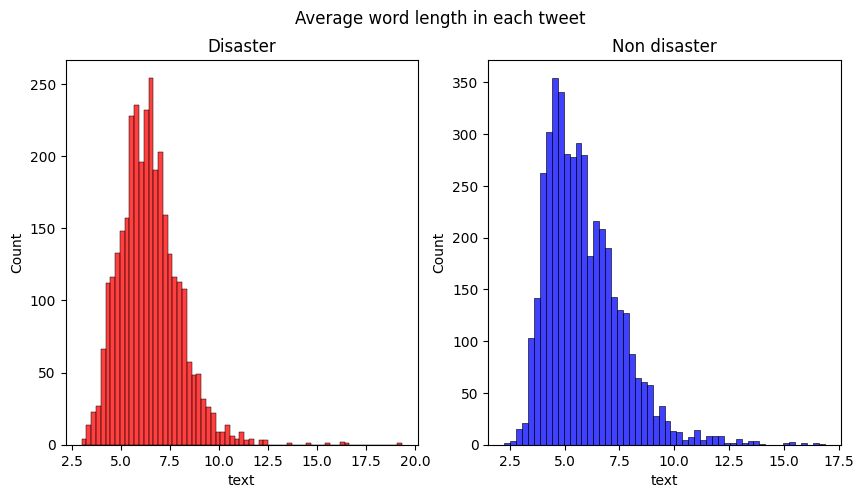

In [10]:
# Average word length in a tweet, disaster vs non disaster

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Disaster')
word = df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='blue')
ax2.set_title('Non disaster')
fig.suptitle('Average word length in each tweet')

Per observation you can see that the distribution of the number of words in the tweet is different between the disaster and non-disaster tweets. The disaster tweets tend to have more words than the non-disaster tweets.

## Word processing

In [11]:
# Words cleaning

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    
    stemmer = nltk.SnowballStemmer("english")
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df_train['text'] = df_train['text'].apply(lambda x: clean_text(x))

df_train['text'].head()

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3         peopl receiv wildfir evacu order california 
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

## Model selection
We are using a simple LSTM model with GloVe embeddings. The model is trained on the training data and validated on the validation data. The model is then used to predict the test data.

In [12]:
df_train['text'].head()

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3         peopl receiv wildfir evacu order california 
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

In [13]:
# Tokenization
word_tokenizer = Tokenizer()

df_train['text_tokenized'] = df_train['text'].copy()
word_tokenizer.fit_on_texts(df_train['text_tokenized'])
X = word_tokenizer.texts_to_sequences(df_train['text_tokenized'])
X = pad_sequences(X)
X

array([[   0,    0,    0, ..., 1464, 2871,   18],
       [   0,    0,    0, ..., 5233, 5234, 1028],
       [   0,    0,    0, ...,  374,  330,  438],
       ...,
       [   0,    0,    0, ...,    0,  450, 1330],
       [   0,    0,    0, ..., 4185, 1007,  105],
       [   0,    0,    0, ...,   99,  567,   13]], dtype=int32)

GloVe (Global Vectors for Word Representation): GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Source: https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt

In [14]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
vocab_length = len(word_tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
y = df_train['target'].values

# Split df_train into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Find the longest sentence length
length_long_sentence = len(X_train[0])
for i in X_train:
    if len(i) > length_long_sentence:
        length_long_sentence = len(i)
print(length_long_sentence)

23


In [ ]:
# Create the LSTM model
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = BLSTM()
model.summary()

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1740902251.902714   17573 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## Model evaluation

NameError: name 'history' is not defined

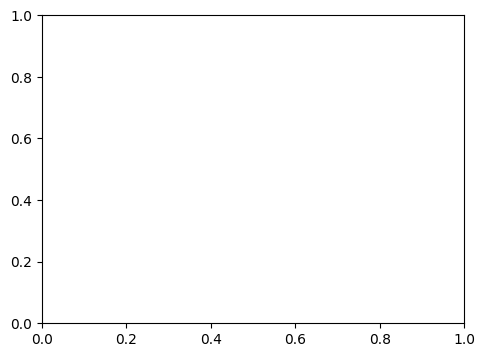

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7442 - loss: 1.0914
Loss: 0.993323564529419
Accuracy: 0.7623112201690674


In [ ]:
preds = model.predict(X_test)

print("F1-score: ", f1_score(preds, y_test))
print("Precision: ", precision_score(preds, y_test))
print("Recall: ", recall_score(preds, y_test))
print("Acuracy: ", accuracy_score(preds, y_test))

print(classification_report(preds, y_test))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


ValueError: Classification metrics can't handle a mix of continuous and binary targets